# 7. Backtesting

Since we didn't consider prepayment timing and monthly installment, this has not been a precise analysis. From this section, let's run the backtesting to see how our investment evolves over time, and what we can expect from our investment.

We ran the backtest on the one year OOT data from 2018Q2 to 2018Q3. The fitted xgb classification model is used for prediction.

In [1]:
import os

# set dir by hardcode to run in crontab
os.chdir("/home/jacob/Project/LendingClub/")

import Data_Helper as DH
import lendingclub
import prediction
import investment
import backtester
import numpy as np
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

In [2]:
# initialize config object
config = lendingclub.ConfigData("config_data_dummy.ini")

# initialize lendingclup api object
lc = lendingclub.LendingClub(config)

# initialize data transformer
transformer = DH.Transformer_full()

# initialize DataHelper
periodStart = ("Q1", "2016")
periodEnd = ("Q1", "2018")
DataHelper = DH.DataHelper(periodStart, periodEnd, transformer, lc)

In [3]:
# set training data
DataHelper.set_training_dataset()

In [3]:
# set test data
DataHelper.set_test_dataset(["LoanStats_2018Q2.csv", "LoanStats_2018Q3.csv"])

In [4]:
# saved model
filename = "xgb_classification_20201223_Prod.sav"

In [5]:
# instantiate from beginning
xgb = prediction.ModelXGBClassfication(filename)

# update from the saved model
xgb.set_model_from_file()

# check model description
xgb.model_description

Model is loaded from xgb_classification_20201223_Prod.sav


'XGBoost Classification Object, time: 12/23/2020, eta: 0.01, num_rounds: 3950, max_depth: 6, subsample: 0.7'

In [6]:
xgb.model.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.7, gamma=0.2, learning_rate=0.01,
              max_delta_step=0, max_depth=6, min_child_weight=5, missing=nan,
              n_estimators=3950, n_jobs=8, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=5,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.7, tree_method='hist')>

## 7.1 Conservaitve Strategy

The first strategy we tried is the simple one which cuts the investment by the model score. Based on the test result, we can expect 3.7% anualized return if invest USD 10k. As expected, most of our investments focused on the A1 grade loans. So our profit of this investments mainly comes from the low default rate and rolling of the money.

Please note that the expected return here is summation of discounted future cash flow by expected default rate and 2.6% annualized interest rate.

In [7]:
strat = investment.StrategyClassSimple(xgb)
print(strat.description())

This strategy chooses loans basaed on the simple score cut. In other words, it only invests to the loans with the model scores lower than the cut. It further filters out the selected loan by FICO score.


In [8]:
opt = investment.StrategyOptimizer(DataHelper, xgb, strat)

In [9]:
initial = 10000
cuts = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]

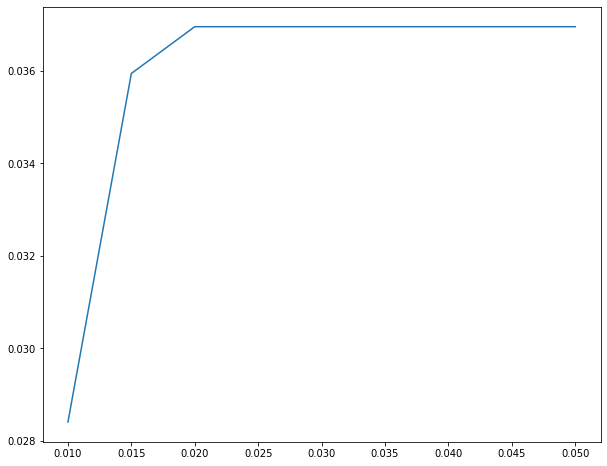

[0.028404843128046444,
 0.035942125614979885,
 0.03695399883682148,
 0.03695399883682148,
 0.03695399883682148,
 0.03695399883682148,
 0.03695399883682148,
 0.03695399883682148,
 0.03695399883682148]

In [10]:
profits = opt.opt_cut_conserv(cuts, initial)
profits

As we can see from below plot, it can handle larger amount without decreasing the return by increasing the cut slightly.

In [14]:
initials = np.array(range(1,7)) * 5000
cuts = [0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]

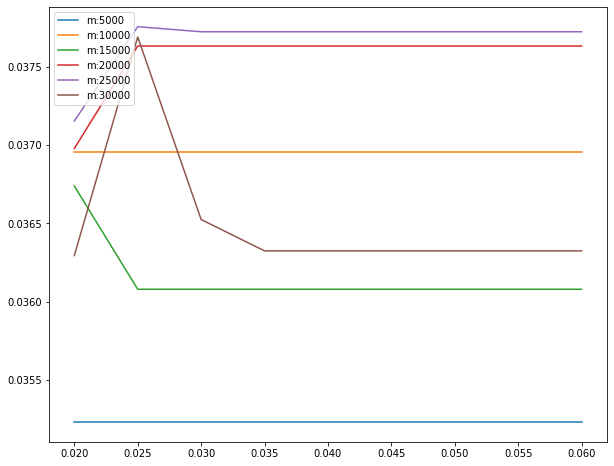

[{'initialInvest': 5000, 'cut': 0.02, 'return': 0.03523265551151216},
 {'initialInvest': 10000, 'cut': 0.02, 'return': 0.03695399883682148},
 {'initialInvest': 15000, 'cut': 0.02, 'return': 0.03673863194608961},
 {'initialInvest': 20000, 'cut': 0.025, 'return': 0.03763183323856634},
 {'initialInvest': 25000, 'cut': 0.025, 'return': 0.03775516068785888},
 {'initialInvest': 30000, 'cut': 0.025, 'return': 0.03768938520410995}]

In [15]:
profits = opt.opt_seed_conserv(cuts, initials)
profits

## 7.2 Aggresive Strategy

3.7% is not too bad, but we can probably do better by simply improving the investment strategy, not the prediction model. So let's explore other strategies here. For the first, we tried the strategy taking risk slightly more agressively, which invest based on the expected return.

In [8]:
strat = investment.StrategyClassComplex(xgb)
print(strat.description())

This strategy chooses loans basaed on the expected payoff. The expected payoff is calculated by the interest rate minus the model score. If the calculated expected payoff is greater than the predefined cut, then it selects a loan. It further filters out the selected loan by FICO score and the loan grade.


In [9]:
opt = investment.StrategyOptimizer(DataHelper, xgb, strat)

Based on the backtesting results, if we invest USD 5K, then we can expect 6.1% when we limit the loans above expected resutn 0.125 and below "C3" grade. While the second best strategy is at B5 and 0.1 which returns 5.9%. These are reasonable profit, considering it is discounted by expected default rate and 2.6% interest rate.

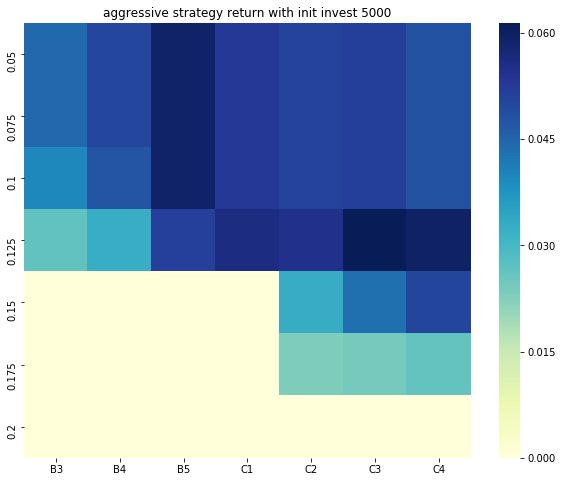

,B3,B4,B5,C1,C2,C3,C4
0.050,0.044463,0.050301,0.059079,0.052856,0.050715,0.051703,0.048170
0.075,0.044463,0.050301,0.059079,0.052856,0.050715,0.051703,0.048170
0.100,0.039623,0.047682,0.059079,0.052856,0.050715,0.051703,0.048170
0.125,0.026866,0.032559,0.051451,0.056108,0.054887,0.061425,0.059526
0.150,0.000000,0.000000,0.000000,0.000000,0.032697,0.043253,0.050422
0.175,0.000000,0.000000,0.000000,0.000000,0.023086,0.024294,0.026235
0.200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
initial = 5000
grades = ["B3", "B4", "B5", "C1", "C2", "C3", "C4"]
cuts = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]

profits = opt.opt_cut_aggr(cuts, grades, initial, plot=True)
profits

Let's explore further, whether we can get the better return if we invest more. The best parameter still remains at 0.1 and "C2" (or "C3" with minor difference). The reason of dereasing profit is due to the holding period. If we look at the investment amounts by month, entire funding cannot invested at first month if funding is larger than 10000. This is why the profit seems to be deteriorated (due to additional discounting). In other words, this does not inndicate the deteriorate of strategy. If we run the strategy long enough, than the difference will be faded out. 

10000


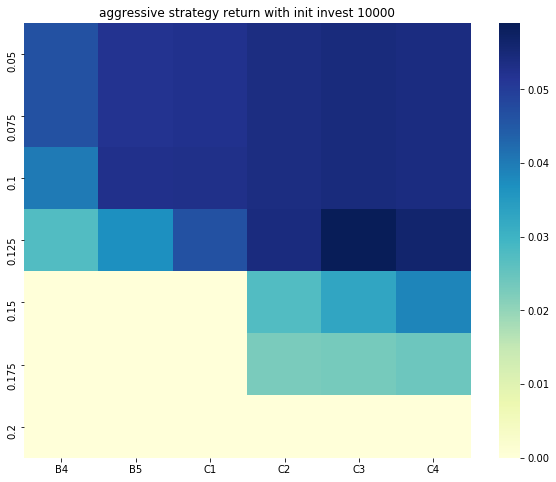

20000


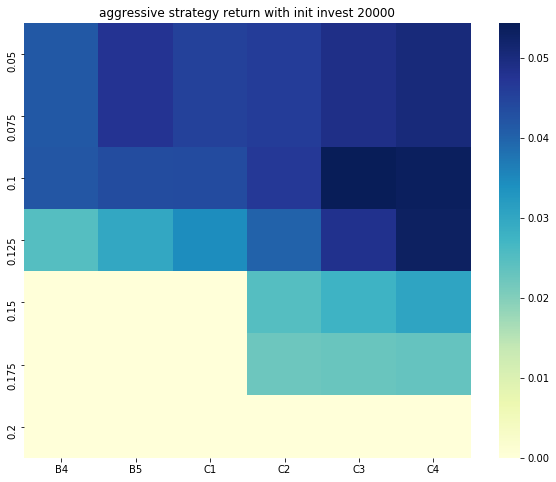

30000


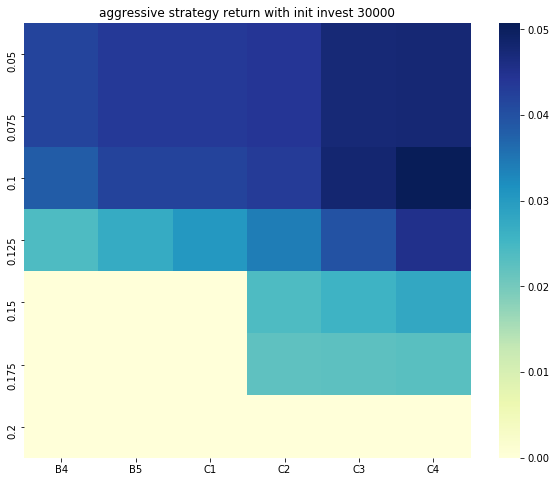

[{'return': 0.05900859529046981,
  'initialInvest': 10000,
  'grade': 'C3',
  'cut': 0.125},
 {'return': 0.05432276012589259,
  'initialInvest': 20000,
  'grade': 'C3',
  'cut': 0.1},
 {'return': 0.05073572644434444,
  'initialInvest': 30000,
  'grade': 'C4',
  'cut': 0.1}]

In [19]:
initials = np.array(range(1,4)) * 10000
grades = ["B4", "B5", "C1", "C2", "C3", "C4"]
cuts = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]

profits = opt.opt_seed_aggr(cuts, grades, initials, plot=True)
profits

We saw that the parameter to acheive the return varies by the seed amount. Realistically, we are not investing more than $5000 in this strategy within the two quarter, so we will choose (C3, 0125) or (B5, 0.1). SO we need t check how many loans, that we are going to actually face, are falling into those buckets.

## 7.3 Aggressive Strategy with adjusted amounts

Can we do better? We can probably increase the profit by adjusting investment amounts for each loan based on the expected retrn. Let's explore the strategy here. We will stick to the parameter 0.125 and "C3". However, we will adjust invest amount by using logistic function on expected return. The slope and maximum of the function will be finetuned through backtesting.

It marginally increases the profits. However, it also added large uncertainty, since the optimal parameters shifted a lot depending on the initial amount invested. Therefore, adjusting amounts does not seem to be necessary in our strategy.

In [22]:
strat = investment.StrategyClassComplexII(xgb)
print(strat.description())

This strategy chooses loans basaed on the expected payoff. The expected payoff is calculated by the interest rate minus the model score. If the calculated expected payoff is greater than the predefined cut, then it selects a loan. It also increase the invest amount for each loan based on the payoff. It further filters out the selected loan by FICO score and the loan grade.


In [23]:
opt = investment.StrategyOptimizer(DataHelper, xgb, strat)

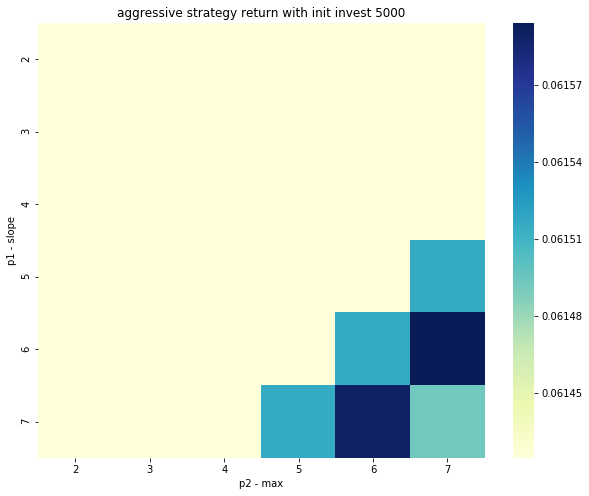

,2,3,4,5,6,7
2,0.061425,0.061425,0.061425,0.061425,0.061425,0.061425
3,0.061425,0.061425,0.061425,0.061425,0.061425,0.061425
4,0.061425,0.061425,0.061425,0.061425,0.061425,0.061425
5,0.061425,0.061425,0.061425,0.061425,0.061425,0.061516
6,0.061425,0.061425,0.061425,0.061425,0.061516,0.061594
7,0.061425,0.061425,0.061425,0.061516,0.061589,0.061493


In [24]:
initial = 5000
slopes = list(range(2,8))
maxs = list(range(2,8))

profits = opt.opt_amountfunc_aggr(slopes, maxs, 0.125, "C3", initial, plot=True)
profits

Until here, let's run

In [19]:
strat.amount_slope = 6
strat.amount_max = 5
strat.cut = 0.125
strat.grade = "C3"

tester = backtester.Backtester(DataHelper, xgb, strat, 1)
tester.initialInvest = 5000
total, C, l, profit = tester.backtest(DataHelper.test, returnAll = True)

 # sort by expected payoff
int_rate = total["int_rate"] / 12
int_rate = np.array([sum(x * np.array([1-i*1/36 for i in range(0, 36)])) for x in int_rate])
expected = int_rate - total["score"]
expected = np.sort(expected)

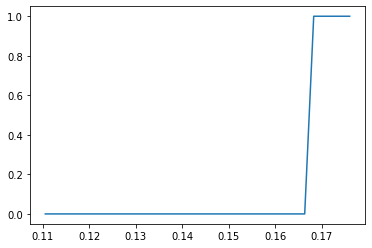

In [20]:
amounts = strat.amounts_func(expected)
plt.plot(expected, amounts)

In [21]:
strat.amount_slope = 7
strat.amount_max = 6
strat.cut = 0.1
strat.grade = "C2"

tester = backtester.Backtester(DataHelper, xgb, strat, 1)
tester.initialInvest = 30000
total, C, l, profit = tester.backtest(DataHelper.test, returnAll = True)

 # sort by expected payoff
int_rate = total["int_rate"] / 12
int_rate = np.array([sum(x * np.array([1-i*1/36 for i in range(0, 36)])) for x in int_rate])
expected = int_rate - total["score"]
expected = np.sort(expected)

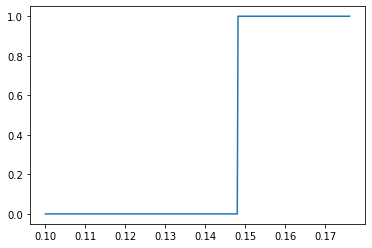

In [22]:
amounts = strat.amounts_func(expected)
plt.plot(expected, amounts)

## Check recent loans to invest

In [25]:
# set test data
DataHelper.set_test_dataset(["LoanStats_2020Q1.csv", "LoanStats_2020Q2.csv", "LoanStats_2020Q3.csv"], includeCurrent=True)

In [26]:
test = DataHelper.test
test.shape

In [36]:
# strategy
strat = investment.StrategyClassComplex(xgb)
strat.grade = "C3"
strat.cut = 0.125

In [37]:
loans = strat.invest_loans(test, backtest=True)
loans.shape

(2439, 102)

In [39]:
summ1 = loans.loc[:,["sub_grade", "int_rate"]].groupby(["sub_grade"]).agg("mean")
cnt = loans.loc[:,["sub_grade", "int_rate"]].groupby(["sub_grade"]).agg("count")
summ1["count"] = cnt

print(sum(summ1["count"]) * 25)
summ1

60975


,int_rate,count
sub_grade,,
A3,0.095600,10
A4,0.101900,27
A5,0.108100,53
B1,0.131231,116
B2,0.136610,234
B3,0.139376,268
B4,0.145327,211
B5,0.153068,291
C1,0.161576,323


In [40]:
# strategy
strat = investment.StrategyClassComplex(xgb)
strat.grade = "B5"
strat.cut = 0.1

In [41]:
loans = strat.invest_loans(test, backtest=True)
loans.shape

(6524, 102)

In [42]:
summ2 = loans.loc[:,["sub_grade", "int_rate"]].groupby(["sub_grade"]).agg("mean")
cnt = loans.loc[:,["sub_grade", "int_rate"]].groupby(["sub_grade"]).agg("count")
summ2["count"] = cnt

print(sum(summ2["count"]) * 25)
summ2

163100


,int_rate,count
sub_grade,,
A1,0.084600,967
A2,0.090200,348
A3,0.094932,509
A4,0.099984,428
A5,0.106068,886
B1,0.122769,527
B2,0.127353,843
B3,0.133032,821
B4,0.139712,548


## Summary

As we can see, the Aggressive strategy performs well producing ~6% annulized return. The strategy we are going to use is the Aggressive one based on the 0.125 cut and "C3" grade. We will not adjust investment money for each loans.

Please note that the key of our profit is really in the prediction model. Improving AUC will end up with higher profits.